In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
import pathlib
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.applications.mobilenet_v2 import decode_predictions
from tensorflow.keras.preprocessing import image
import skimage
from skimage import io
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/project/model')

In [ ]:
model.summary()

Model: "MobileNetV2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, None, None, 1280)  2257984   
_________________________________________________________________
avg_pool (GlobalAveragePooli (None, 1280)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1280)              5120      
_________________________________________________________________
top_dropout (Dropout)        (None, 1280)              0         
_________________________________________________________________
pred (Dense)                 (None, 2)                 2562      
_________________________________________________________________
activation (Activation)      (None, 2)                 

In [ ]:
# last_conv_layer = model.layers[1].get_output_at(-1)
# last_conv_layer_model = keras.Model(model.inputs, last_conv_layer)
# # layer_model = keras.Model(model.inputs, model.layers[1].output)
# # print(last_conv_layer)
# # print(model.inputs)
# last_conv_layer_model.summary()

In [ ]:
# model2=tf.keras.applications.MobileNetV2(weights='imagenet',include_top=False)

In [ ]:
# model2.summary()

Grad-Cam Definition

In [ ]:
def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    # last_conv_layer = model.layers[1].get_layer(last_conv_layer_name)
    last_conv_layer = model.layers[1].get_output_at(-1)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        # print(preds)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]
        # print(top_class_channel)

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)
    
    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    print(tf.math.reduce_max(pooled_grads))
    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]
    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)
    # print(heatmap)
    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    # print(heatmap)
    return heatmap

Read Test data

In [ ]:
datadir1 = "/content/drive/MyDrive/project/test.zip (Unzipped Files)/test"
data_test = pathlib.Path(datadir1)

# ds_test = tf.keras.preprocessing.image_dataset_from_directory(
#     data_test,
#     batch_size=32,
#     image_size=(224, 224))

datagen_noaug = ImageDataGenerator(rescale=1./255)

test_generator = datagen_noaug.flow_from_directory(
    directory=data_test,
    shuffle=False,
    target_size=(224,224),
    batch_size=1,
    class_mode='binary')

Found 125 images belonging to 2 classes.


In [ ]:
img_path = "/content/drive/MyDrive/project/video.zip (Unzipped Files)/video/video1/frame0.jpg"

img = keras.preprocessing.image.load_img(img_path,target_size=(224,224))
input_arr = keras.preprocessing.image.img_to_array(img)
input_arr = np.array([input_arr])  # Convert single image to a batch.
input_arr = input_arr/255
predictions = model.predict(input_arr)
print(predictions)

[[0.00285379 0.9971462 ]]


In [ ]:
pred = model.predict(test_generator[63][0])
print(pred)

[[1.1663189e-05 9.9998832e-01]]


(224, 224, 3)


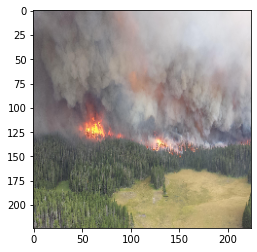

In [ ]:
img_num = 93
print(test_generator[img_num][0][0].shape)
plt.imshow(test_generator[img_num][0].squeeze())

tf.Tensor(0.048679017, shape=(), dtype=float32)


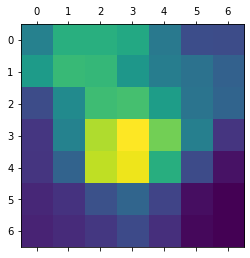

In [ ]:
last_conv_layer_name = "out_relu" 
classifier_layer_names = [
    "avg_pool",
    "batch_normalization",
    "top_dropout",
    "pred",
]

img_array = test_generator[img_num][0]
# print(img_array.max())

def get_img_array(img_generator):
    # `img` is a PIL image of size 299x299
    img = img_generator
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array
    
# img_array = tf.keras.applications.mobilenet_v2.preprocess_input(get_img_array(test_generator[74][0][0]))
heatmap = make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
)

# Display heatmap
plt.matshow(heatmap)
plt.show()

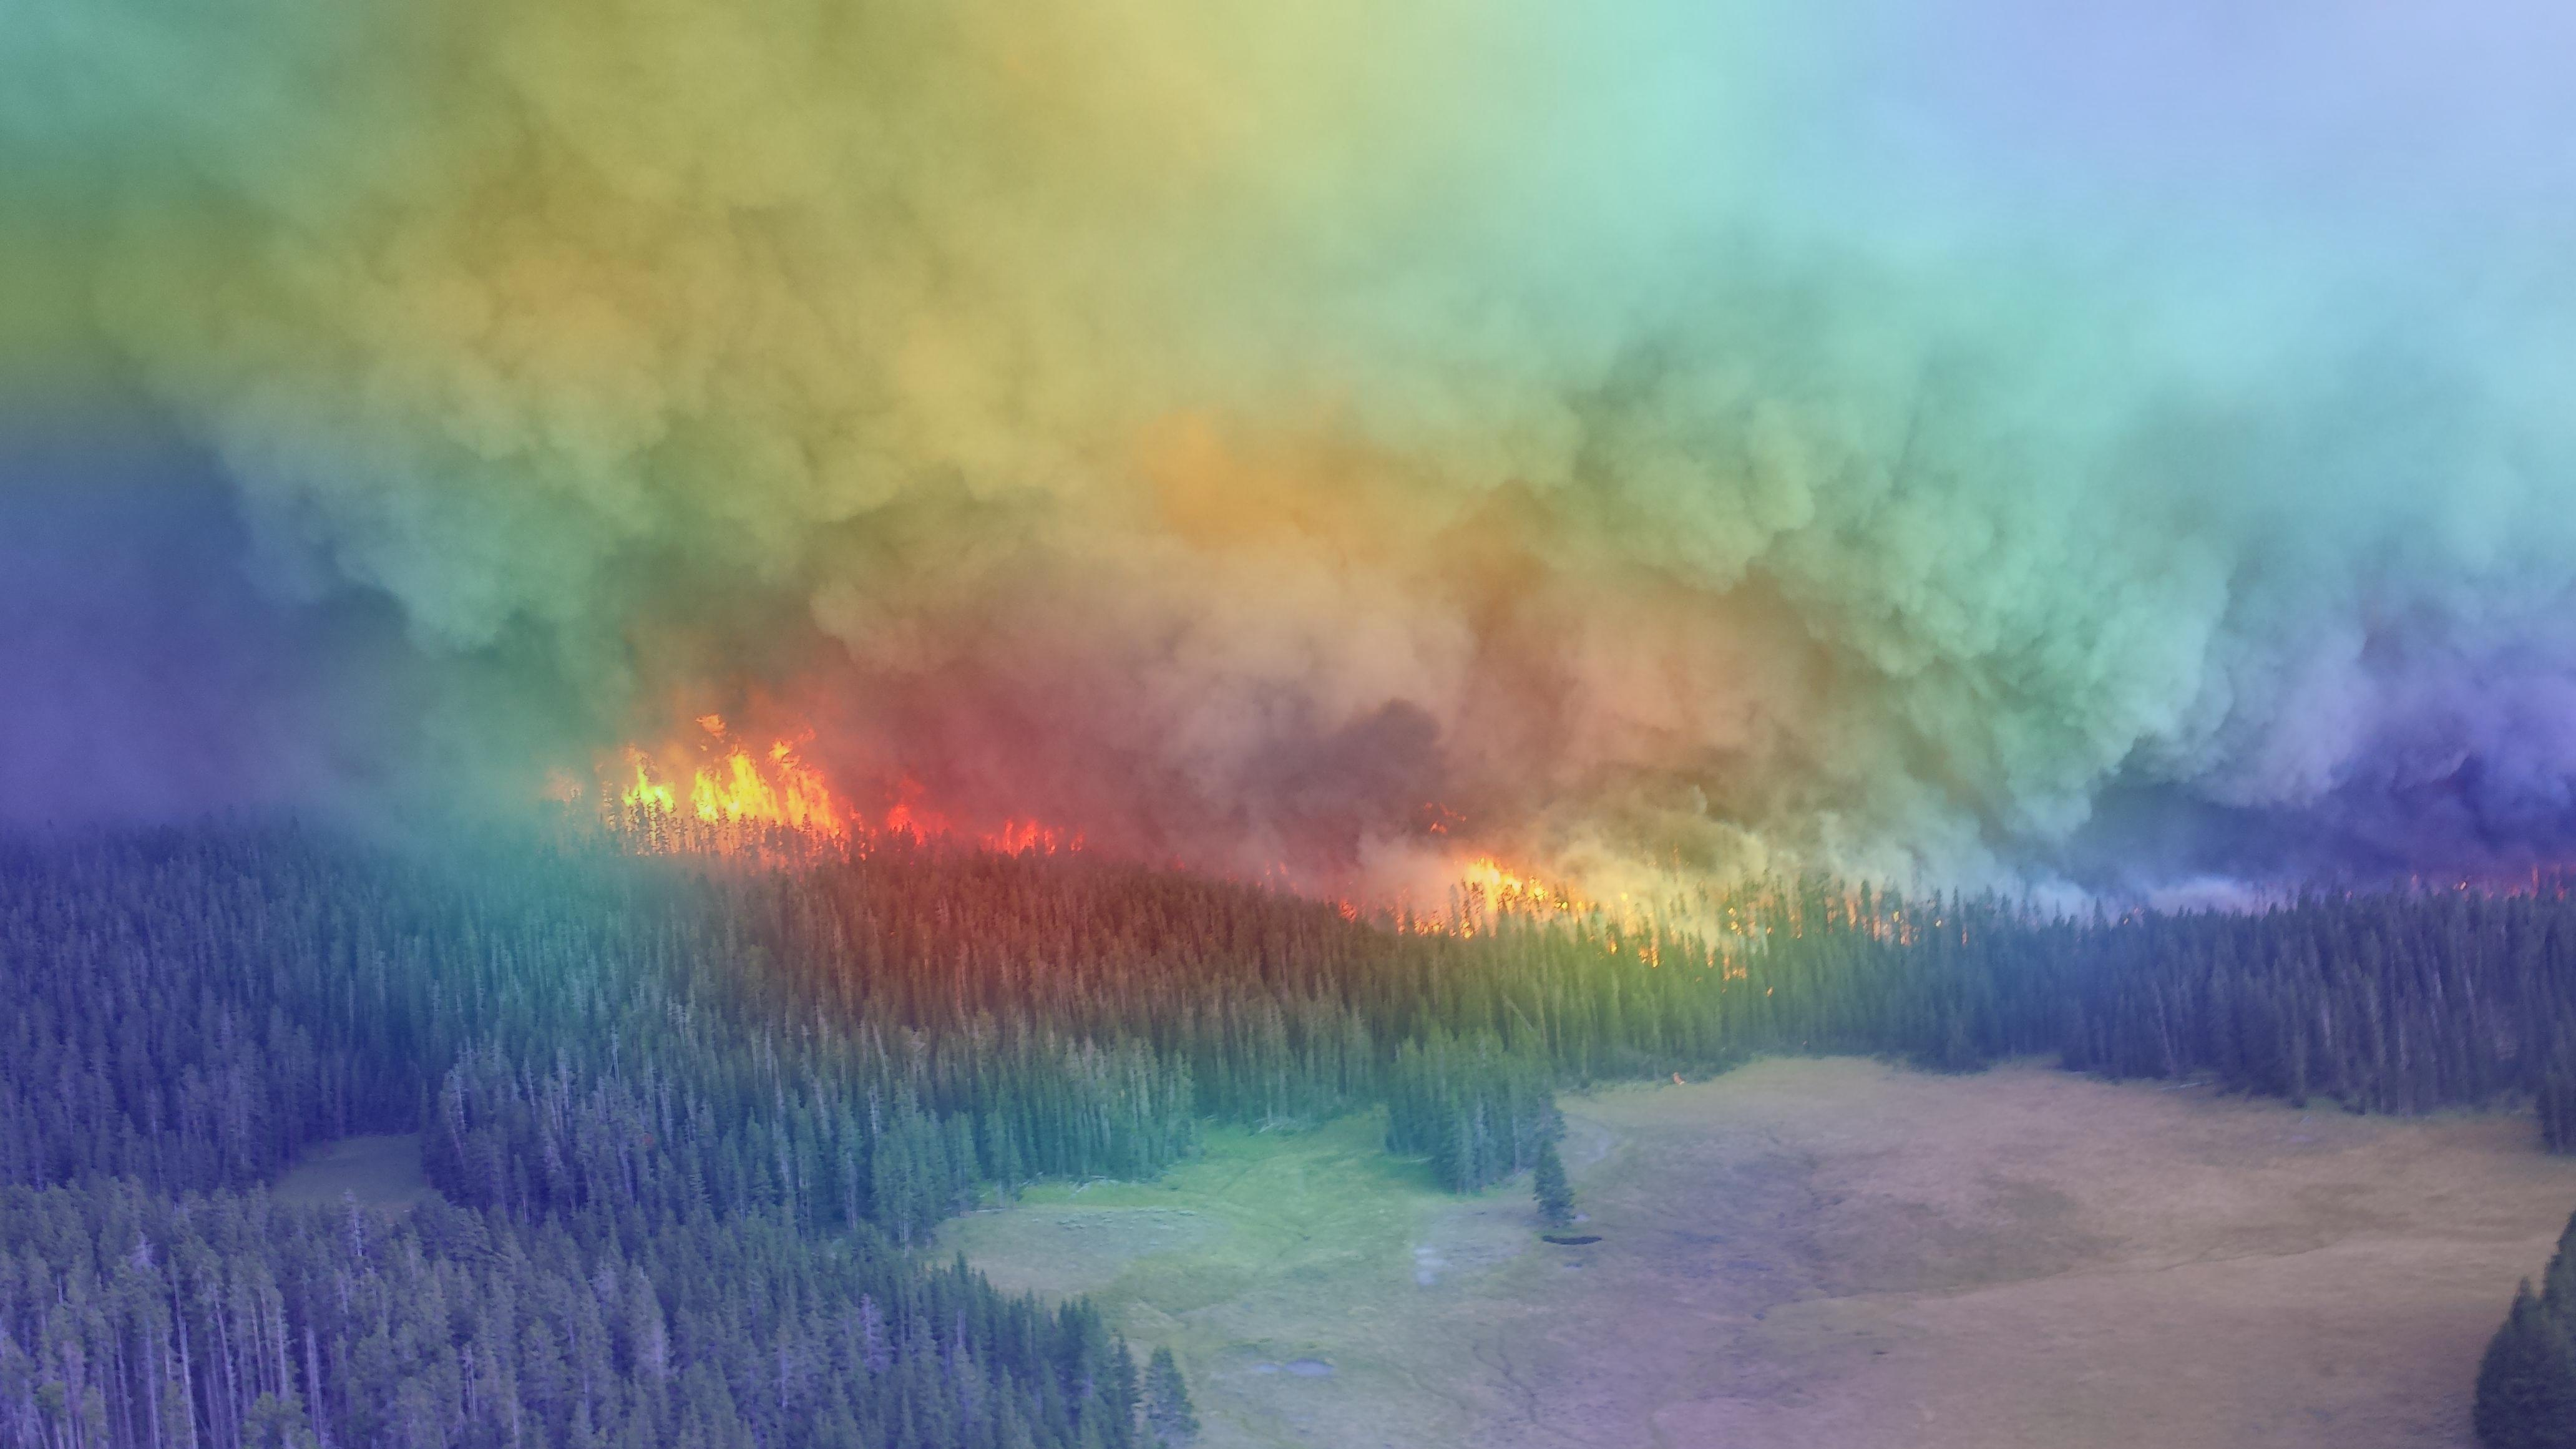

In [ ]:
import matplotlib.cm as cm
from IPython.display import Image
img_path = "/content/drive/MyDrive/project/test.zip (Unzipped Files)/test/smoke/00000035.jpg"
# We load the original image
img = keras.preprocessing.image.load_img(img_path)
img = keras.preprocessing.image.img_to_array(img)

# We rescale heatmap to a range 0-255
heatmap = np.uint8(255 * heatmap)

# We use jet colormap to colorize heatmap
jet = cm.get_cmap("jet")

# We use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# We create an image with RGB colorized heatmap
jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

# Superimpose the heatmap on original image
superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

# Save the superimposed image
save_path = "/content/drive/MyDrive/project/grad-cam/False1.jpg"
superimposed_img.save(save_path)

# Display Grad CAM
display(Image(save_path))

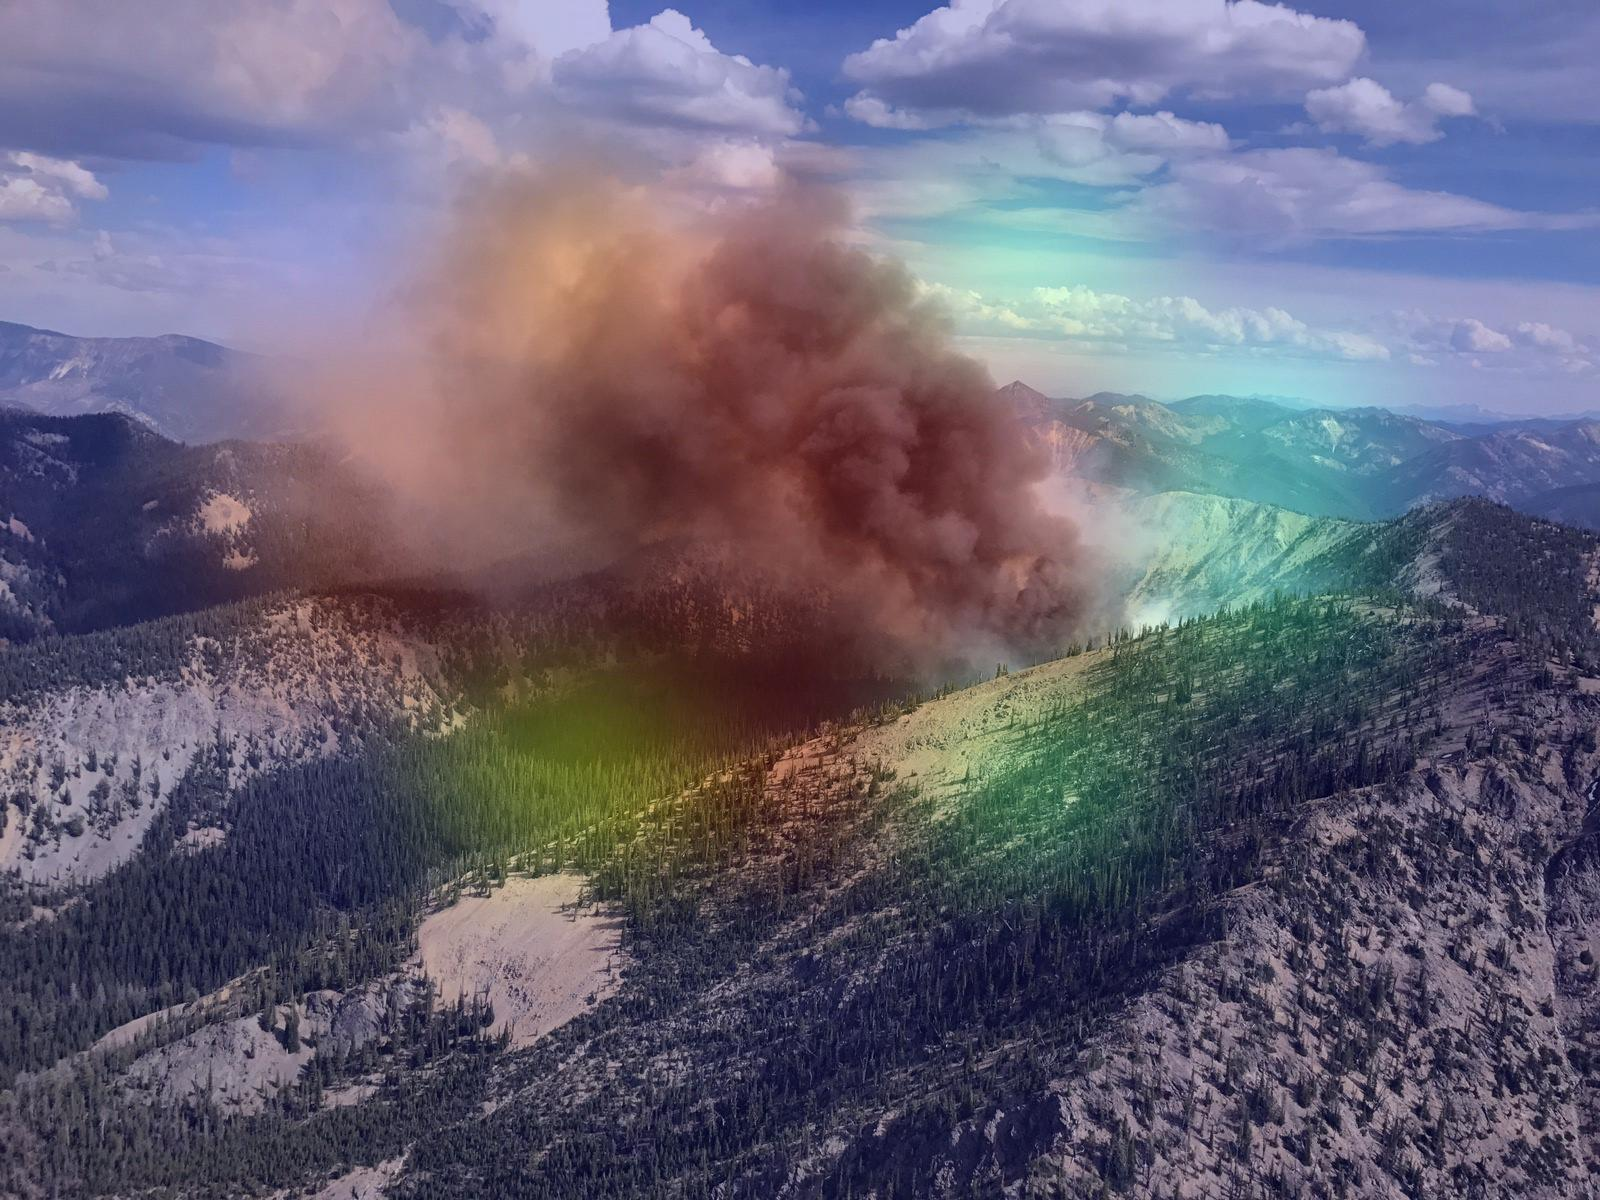

In [ ]:
import matplotlib.cm as cm
from IPython.display import Image
img_path = "/content/drive/MyDrive/project/test.zip (Unzipped Files)/test/smoke/00000001.jpg"
# We load the original image
img = keras.preprocessing.image.load_img(img_path)
img = keras.preprocessing.image.img_to_array(img)

# We rescale heatmap to a range 0-255
heatmap = np.uint8(255 * heatmap)

# We use jet colormap to colorize heatmap
jet = cm.get_cmap("jet")

# We use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# We create an image with RGB colorized heatmap
jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

# Superimpose the heatmap on original image
superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

# Save the superimposed image
save_path = "/content/drive/MyDrive/project/grad-cam/test2.jpg"
superimposed_img.save(save_path)

# Display Grad CAM
display(Image(save_path))

Test Model

In [ ]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_generator, batch_size=1)
print("test loss, test acc:", results)

Evaluate on test data
125/125 [==============================] - 44s 347ms/step - loss: 0.0767 - accuracy: 0.9760
test loss, test acc: [0.07671535760164261, 0.9760000109672546]


In [ ]:
# test_generator.reset()
# predict = model.predict_generator(
#     test_generator,
#     steps=len(test_generator),
#     workers = 1,
#     use_multiprocessing=False)

predict = model.predict(test_generator)

In [ ]:
print('prediction norm:\n',predict[0:61])

prediction norm:
 [[9.99997020e-01 3.01275350e-06]
 [1.00000000e+00 0.00000000e+00]
 [1.00000000e+00 0.00000000e+00]
 [1.00000000e+00 0.00000000e+00]
 [1.00000000e+00 8.78181795e-23]
 [1.00000000e+00 8.78181795e-23]
 [1.00000000e+00 0.00000000e+00]
 [1.00000000e+00 0.00000000e+00]
 [1.00000000e+00 0.00000000e+00]
 [9.99943852e-01 5.60849112e-05]
 [1.00000000e+00 0.00000000e+00]
 [1.00000000e+00 0.00000000e+00]
 [1.00000000e+00 0.00000000e+00]
 [1.00000000e+00 7.95788943e-18]
 [1.00000000e+00 0.00000000e+00]
 [1.00000000e+00 1.13174157e-20]
 [9.89898860e-01 1.01011135e-02]
 [9.95649397e-01 4.35065711e-03]
 [1.00000000e+00 0.00000000e+00]
 [1.00000000e+00 0.00000000e+00]
 [1.00000000e+00 0.00000000e+00]
 [1.00000000e+00 4.46663555e-15]
 [1.00000000e+00 2.33991760e-17]
 [1.00000000e+00 5.21034835e-14]
 [1.00000000e+00 5.33059138e-22]
 [1.00000000e+00 6.06944502e-25]
 [1.00000000e+00 1.73940720e-35]
 [1.00000000e+00 7.18273278e-22]
 [1.00000000e+00 7.18273278e-22]
 [1.00000000e+00 9.283547

In [ ]:
print('prediction norm:\n',predict[62:])

prediction norm:
 [[6.19317289e-04 9.99380708e-01]
 [1.16631891e-05 9.99988317e-01]
 [3.08681433e-06 9.99996901e-01]
 [8.18447461e-07 9.99999166e-01]
 [3.86481232e-04 9.99613583e-01]
 [2.88766273e-08 1.00000000e+00]
 [5.63422100e-06 9.99994397e-01]
 [7.79563705e-11 1.00000000e+00]
 [2.32395716e-04 9.99767601e-01]
 [2.54524571e-06 9.99997497e-01]
 [9.83926833e-01 1.60731878e-02]
 [9.37872887e-01 6.21270649e-02]
 [2.52269879e-02 9.74772990e-01]
 [4.17165438e-06 9.99995828e-01]
 [1.96343553e-05 9.99980330e-01]
 [1.51942920e-08 1.00000000e+00]
 [1.43531695e-04 9.99856472e-01]
 [3.47563728e-05 9.99965191e-01]
 [3.15944853e-05 9.99968410e-01]
 [5.21834124e-07 9.99999523e-01]
 [4.94260818e-01 5.05739212e-01]
 [4.41274559e-03 9.95587230e-01]
 [1.01875805e-03 9.98981178e-01]
 [5.64997783e-04 9.99435008e-01]
 [4.15424751e-07 9.99999642e-01]
 [5.84123256e-07 9.99999404e-01]
 [3.90267063e-09 1.00000000e+00]
 [1.34737065e-05 9.99986529e-01]
 [8.79636355e-05 9.99912024e-01]
 [1.11002578e-06 9.999989

In [ ]:
smoke = predict[62:]
for i in range(len(smoke)):
  if(smoke[i][0]>smoke[i][1]):
    print(smoke[i],i)

[0.98392683 0.01607319] 10
[0.9378729  0.06212706] 11
[0.7946846 0.2053154] 36


In [ ]:
# img = image.load_img('/content/drive/MyDrive/project/test.zip (Unzipped Files)/test/normal/00000325.jpg'
#                           , target_size=(224, 224))
# img_array = image.img_to_array(img)

# img_batch = np.expand_dims(img_array, axis=0)
# img_batch = img_batch/255
# # img_preprocessed = tf.keras.applications.mobilenet_v2.preprocess_input(img_batch) 
# pred = model.predict_generator(
#     img_preprocessed,
#     steps=len(test_generator),
#     workers = 1,
#     use_multiprocessing=False)
# # pred = model.predict(img_preprocessed)
# print(pred)

In [ ]:
img = image.load_img('/content/drive/MyDrive/project/test.zip (Unzipped Files)/test/normal/00000124.jpg'
                          , target_size=(224, 224))
img_array = image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)
print(img_batch.min())
img_preprocessed = tf.keras.applications.mobilenet_v2.preprocess_input(img_batch) 
pred = model.predict(img_preprocessed)


# image = tf.keras.preprocessing.image.load_img('/content/drive/MyDrive/project/test.zip (Unzipped Files)/test/smoke/00000016.jpg'
#                            , target_size=(224, 224))
# input_arr = keras.preprocessing.image.img_to_array(image)
# input_arr = np.array([input_arr])  # Convert single image to a batch.
# pred = model.predict(input_arr)
print(img_preprocessed.min())
print(pred)
print(model(img_preprocessed))

0.0
-1.0
[[0.]]
tf.Tensor([[0.]], shape=(1, 1), dtype=float32)
